In [1]:
!pip install segmentation-models
!pip install tensorflow==2.1.0
!pip install keras==2.3.1

     |████████████████████████████████| 50 kB 4.7 MB/s 
     |████████████████████████████████| 421.8 MB 22 kB/s 
     |████████████████████████████████| 448 kB 65.7 MB/s 
     |████████████████████████████████| 3.8 MB 24.9 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=592280e33606c2cda7840e3aaa03e8507762a5ead264c1b853da434a3e226756
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Succes

In [20]:
!pip install livelossplot
%matplotlib inline

In [3]:
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.utils import normalize, to_categorical

Using TensorFlow backend.


In [5]:
import tensorflow as tf
import segmentation_models as sm
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [6]:
#Resizing images 
SIZE_X = 128 #Resize images (height  = X, width = Y)
SIZE_Y = 128

#Capture training image info as a list
train_images = []

for directory_path in glob.glob("/content/drive/MyDrive/A3_Dataset/dataset1/images_prepped_train"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
   
#Convert list to array        
train_images = np.array(train_images)
#Capture mask info as a list
train_masks = [] 
for directory_path in glob.glob("/content/drive/MyDrive/A3_Dataset/dataset1/annotations_prepped_train"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        mask = mask.astype(np.float)
        train_masks.append(mask)
#Convert list to array     
train_masks = np.array(train_masks)

In [7]:
X = train_images
Y = train_masks
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

x_train = normalize (x_train, axis =1)
y_train = normalize (y_train, axis=1)
# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)




In [7]:
#Data Augmentation
train_datagen = ImageDataGenerator(rotation_range=45,
    width_shift_range=0.2,
    zoom_range = 0.2,
    horizontal_flip = True)
train_datagen.fit(x_train)

train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size = 32)

In [8]:
sm.set_framework('tf.keras')


In [2]:
!pip uninstall h5py
!pip install h5py==2.10.0

Found existing installation: h5py 3.1.0
Uninstalling h5py-3.1.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/h5py-3.1.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libaec-9c9e97eb.so.0.0.10
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libhdf5-00e8fae8.so.200.0.0
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libhdf5_hl-383c339f.so.200.0.0
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libsz-e7aa62f5.so.2.0.1
    /usr/local/lib/python3.7/dist-packages/h5py.libs/libz-eb09ad1d.so.1.2.3
    /usr/local/lib/python3.7/dist-packages/h5py/*
Proceed (y/n)? y
  Successfully uninstalled h5py-3.1.0
     |████████████████████████████████| 2.9 MB 4.9 MB/s 


In [9]:
 
sm.Unet()
opt = tf.keras.optimizers.SGD(learning_rate=0.1)
model = sm.Unet(BACKBONE, encoder_weights='imagenet',input_shape=(SIZE_X, SIZE_Y, 3))
model.compile(optimizer= opt, loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score],)

print(model.summary())

85524480/85521592 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 128, 128, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
___________________________

In [10]:
history=model.fit(
   x=x_train,
   y=y_train,
   batch_size=32,
   epochs=15,
   verbose=1,
   validation_data=(x_val, y_val),
)

Train on 293 samples, validate on 74 samples
Epoch 1/15
293/293 [==============================] - 124s 424ms/sample - loss: 1.3433 - iou_score: 0.0540 - val_loss: 4.3395 - val_iou_score: 0.3118
Epoch 2/15
293/293 [==============================] - 113s 387ms/sample - loss: 1.2247 - iou_score: 0.0471 - val_loss: 3.5436 - val_iou_score: 0.3800
Epoch 3/15
293/293 [==============================] - 113s 385ms/sample - loss: 1.2160 - iou_score: 0.0470 - val_loss: 3.7922 - val_iou_score: 0.3576
Epoch 4/15
293/293 [==============================] - 112s 383ms/sample - loss: 1.2113 - iou_score: 0.0483 - val_loss: 3.7435 - val_iou_score: 0.3580
Epoch 5/15
293/293 [==============================] - 113s 386ms/sample - loss: 1.2085 - iou_score: 0.0489 - val_loss: 4.1073 - val_iou_score: 0.3240
Epoch 6/15
293/293 [==============================] - 115s 391ms/sample - loss: 1.2062 - iou_score: 0.0494 - val_loss: 4.4720 - val_iou_score: 0.2942
Epoch 7/15
293/293 [==============================] - 1

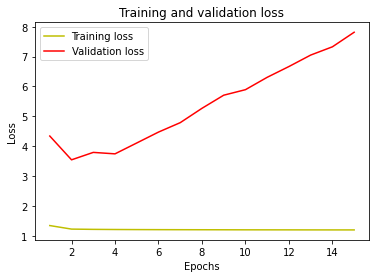

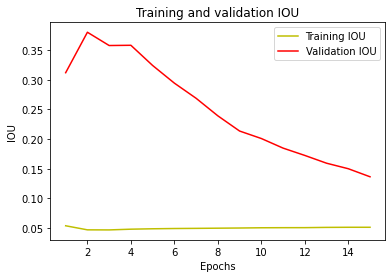

In [11]:
#LOSS AND IOU GRAPHS
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()


In [12]:
y_pred=model.predict(x_val)
y_pred_argmax=np.argmax(y_pred, axis=3)

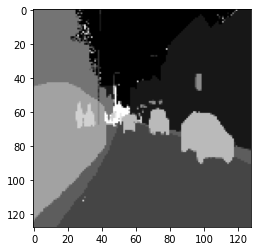

In [13]:
plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')

In [14]:
SIZE_X = 128 #Resize images (height  = X, width = Y)
SIZE_Y = 128

test_images = []
for directory_path in glob.glob("/content/drive/MyDrive/A3_Dataset/dataset1/images_prepped_test"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
#Convert list to array    
test_images = np.array(test_images)

#Capture mask/label info as a list
test_masks = [] 
for directory_path in glob.glob("/content/drive/MyDrive/A3_Dataset/dataset1/annotations_prepped_test"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        mask = mask.astype(np.float)        
        test_masks.append(mask)       
#Convert list to array           
test_masks = np.array(test_masks)

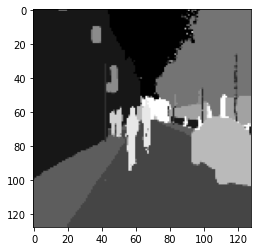

In [48]:
plt.imshow(test_images[0, :,:,0], cmap='gray')
plt.imshow(test_masks[2], cmap='gray')